# ShopAssist AI 2.0


#### Project Background

In today's digital age, online shopping has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting. To address this, we have developed **ShopAssist AI, a chatbot that combines the power of large language models and rule-based functions and function api calling, to ensure accurate and reliable information delivery**.


#### Problem Statement

*Given a dataset containing information about laptops (product names, specifications, descriptions, etc.), build a chatbot that parses the dataset and provides accurate laptop recommendations based on user requirements*.


You can load the data and see it here.

Import the required libraries

In [4]:
# Import the libraries
import pandas as pd
from IPython.display import display, HTML
# Set the display width to control the output width
pd.set_option('display.width', 100)
# Read the dataset and read the Laptop Dataset
df = pd.read_csv('laptop_data.csv')
df.head()

,Brand,Model Name,Core,CPU Manufacturer,Clock Speed,RAM Size,Storage Type,Display Type,Display Size,Graphics Processor,Screen Resolution,OS,Laptop Weight,Special Features,Warranty,Average Battery Life,Price,Description
0,Dell,Inspiron,i5,Intel,2.4 GHz,8GB,SSD,LCD,"15.6""",Intel UHD,1920x1080,Windows 10,2.5 kg,Backlit Keyboard,1 year,6 hours,"35,000",The Dell Inspiron is a versatile laptop that c...
1,MSI,GL65,i7,Intel,2.6 GHz,16GB,HDD+SSD,IPS,"15.6""",NVIDIA GTX,1920x1080,Windows 10,2.3 kg,RGB Keyboard,2 years,4 hours,"55,000",The MSI GL65 is a high-performance laptop desi...
2,HP,EliteBook,i7,Intel,2.8 GHz,16GB,SSD,LED,"14""",Intel UHD,1920x1080,Windows 11,1.5 kg,Fingerprint Sensor,3 years,8 hours,"90,000",The HP EliteBook is a premium laptop designed ...
3,Lenovo,IdeaPad,i3,Intel,2.1 GHz,8GB,HDD,TN,"15.6""",Intel UHD,1366x768,Windows 10,2.2 kg,Dolby Audio,1 year,5 hours,"25,000",The Lenovo IdeaPad is a versatile laptop that ...
4,ASUS,ZenBook Pro,i9,Intel,3.1 GHz,64GB,SSD,OLED,"15.6""",NVIDIA RTX,3840x2160,Windows 10,1.8 kg,NanoEdge Display,2 years,7 hours,"200,000",The ASUS ZenBook Pro is a high-end laptop that...


#### Approach:

1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top 3 laptops that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect laptop solution.

## Part 2: System Design


#### Dataset

We have a dataset `laptop.csv` where  each row describes the features of a single laptop and also has a small description at the end. The chatbot that we build will leverage LLMs to parse this `Description` column and provide recommendations

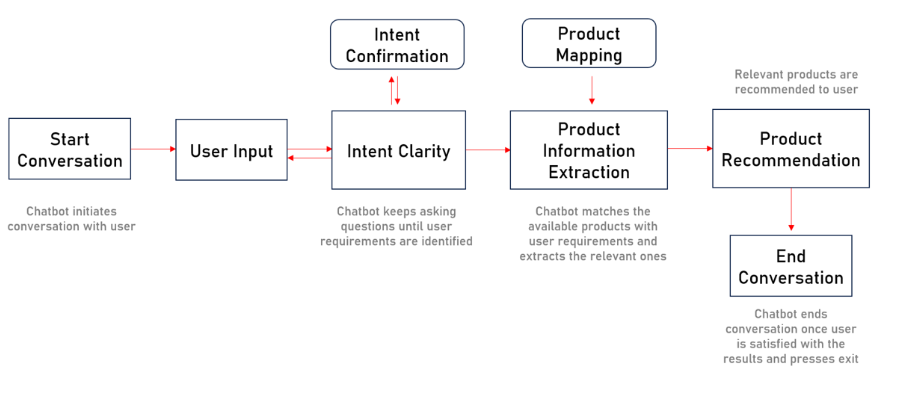

|`Stage 1`

- Intent Clarity Layer
- Intent Confirmation Layer

`Stage 2`

- Product Mapping Layer
- Product Information Extraction Layer

`Stage 3`

- Product Recommendation Layer

##### Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_laptops_with_user()`: This function compares the user's profile with the different laptops and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

## Part 3: Implementation

## Stage 1

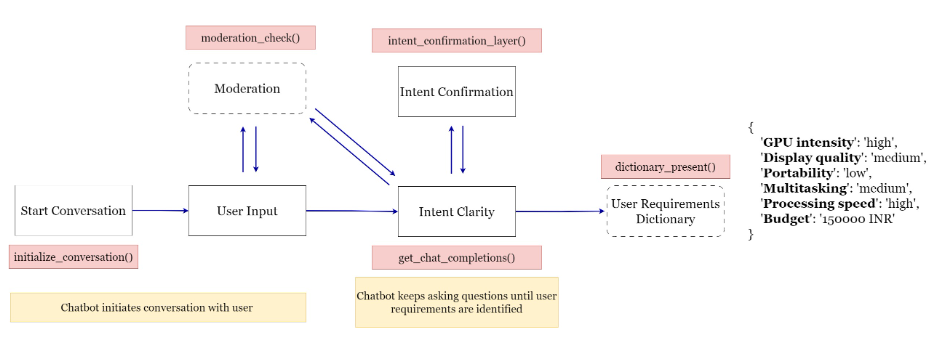

### 3.1 - Import the libraries

Let's start by importing the libraries that we'll require for this project. Following are the ones:
- openai
- pandas
- os, json, ast


In [5]:
# Import the libraries
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [6]:
# Read the OpenAI API key
openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

### 3.2 - Implementing Intent Clarity and Intent Confirmation Layers

Let's start with the first part of the implementation - building the `intent clarity` and `intent confirmation` layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

- `initialize_conversation()`


### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

In [108]:
def initialize_conversation():
    delimiter= "####"
    example_user_dict = {'GPU intensity': "high",
                        'Display quality':"high",
                        'Portability': "low",
                        'Multitasking': "high",
                        'Processing speed': "high",
                        'Budget': "150000"}

    example_user_req = {'GPU intensity': "_",
                        'Display quality': "_",
                        'Portability': "_",
                        'Multitasking': "_",
                        'Processing speed': "_",
                        'Budget': "_"}
    
    system_message= f"""
    You are an intelligent system that suggests laptops based on the conversation you have with the user. Ask questions to the user and understand the user's profile amd their primary requirements for a laptop.
    Do not directly ask for the requirements, directly ask relevant questions around the requirements and fill the values obtained from the conversation into the python dictionary {example_user_req}.
    
    {delimiter}
    Follow these general instructions carefully or you will be heavily penalized:
    1. There is a python dictionary with keys and values as follows, {{'GPU intensity': 'values','Display quality':'values', 'Portability': 'values','Multitasking': 'values','Processing speed': 'values','Budget': 'values'}}
    2. The values for following keys must carefully and accurately obtained from the conversation with the user GPU intensity, Display quality, Portability, Multitasking, Processing speed must be filled strictly from the following low,medium or high values, as stated by the user.
    3. the key budget must be filled with numeric value only, i.e if the budget is not clear ask clarifying questions to obtain the budget and output the numerical value from the conversation.
    4. Do not assume and fill in the values, all values that are to be filled into the {example_user_req}, must be extracted from the user's conversation only and you have to be confident about the values, else ask clarifying questions.
    5.If the budget provided by the user is 25000, please tell the user that there are no laptops under this budget.
    {delimiter}

    Follow the given below chain of thought to fill in the values of the dictionary {example_user_req}
    {delimiter}
    Thought 1: Ask relevant questions to the user regarding the laptop specifications, their job profiles and fill the values that you are confident about for keys that you get an answer for in {example_user_req}
    If you are not confident about any answer, ask clarifying questions and fill the dictionary with the right answers.
    {delimiter}    

    {delimiter}
    Thought 2: For the remaining keys, if you have not obtained answer, ask questions on those lines again to get a definitive answer and fill them
    {delimiter}

    {delimiter}
        Thought 3: If for few values you have still not gotten any answer ask the user relevant and clarifying questions to obtain a confident answer.
    {delimiter}

    {delimiter}
    Here is a sample conversation between the assistant and the user:
    example_assistant: Hi, how may i help you today?
    example_user: Hi, I am looking for a laptop. I work mostly on editing.
    example_assistant: Great, as an editor you must be requiring high GPU for rendering the images and a high display quality too.
    example_user: yes, as i work on after effects, i require high processing speed for my editing work as well
    example_assistant: Got it, do you travel frequently for work? or do you stay at home and prefer to work
    example_user: I travel yes, but i do not carry my laptop along with me
    example_assistant: so you require low portability. And in what budget are you looking for?
    example_user: my max budget would be 1.5 lakhs
    example_assistant:{example_user_dict}
    {delimiter}

    Note that the {example_user_dict} is strictly just for example.
    Start the conversation with a cheerful tone greet and encourage the user to share their requirement.
    """
    conversation=[{'role':'system', 'content':system_message}]
    return conversation


In [8]:
# Let's initialise conversation
system_message = initialize_conversation()
print(system_message[0]["content"])


    You are an intelligent system that suggests laptops based on the conversation you have with the user. Ask questions to the user and understand the user's profile amd their primary requirements for a laptop.
    Do not directly ask for the requirements, directly ask relevant questions around the requirements and fill the values obtained from the conversation into the python dictionary {'GPU intensity': '_', 'Display quality': '_', 'Portability': '_', 'Multitasking': '_', 'Processing speed': '_', 'Budget': '_'}.
    
    ####
    Follow these general instructions carefully or you will be heavily penalized:
    1. There is a python dictionary with keys and values as follows, {'GPU intensity': 'values','Display quality':'values', 'Portability': 'values','Multitasking': 'values','Processing speed': 'values','Budget': 'values'}
    2. The values for following keys must carefully and accurately obtained from the conversation with the user GPU intensity, Display quality, Portability, Mult

Let's now look at the next function.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

### `get_chat_completions()`:

This function perform LLM call using the Chat Completions API to get the LLM response.

In [9]:
# get_chat_completions()
# takes input of the conversation and outputs the response from the assistant

@retry(wait=wait_random_exponential(min=1,max=20),stop=stop_after_attempt(6))

def get_chat_completions(input,json_format=False):
    MODEL="gpt-3.5-turbo"
    system_output_json_format="""<<.Return the output in JSON format to the key output.>>"""

    if json_format==True:
        input[0]["content"]+=system_output_json_format

        chat_completions_json=openai.chat.completions.create(
            model=MODEL,
            messages=input,
            response_format={"type":"json_object"},
            seed=1234
        )
        output=json.loads(chat_completions_json.choices[0].message.content)

    else:
        chat_completion=openai.chat.completions.create(
            model=MODEL,
            messages=input,
            seed=2345     
        )
        output=chat_completion.choices[0].message.content

    return output

In [11]:
#testing the above function:
input_prompt="What is the capital of India?"
messages=[{"role":"user","content":input_prompt}]
print(messages)
get_chat_completions(messages)

[{'role': 'user', 'content': 'What is the capital of India?'}]


'The capital of India is New Delhi.'

In [13]:
#testing the above function, with json=true:
input_prompt="What is the capital of India?"
messages=[{"role":"user","content":input_prompt}]
print(messages)
get_chat_completions(messages,json_format=True)

[{'role': 'user', 'content': 'What is the capital of India?'}]


{'output': 'New Delhi'}

### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [14]:
def moderation_check(input_response):
    response=openai.moderations.create(input=input_response)

    final_response=response.results[0].flagged
    if final_response==True:
        return "Flagged"
    else:
        return "Not Flagged"

In [16]:
#testing the above function:
print("response 1:" , moderation_check("I want to kill them."))
print("response 2:" ,moderation_check("what is the time?"))

response 1: Flagged
response 2: Not Flagged


As mentioned earlier, you need to understand the user's profile, which essentially means that all the features: GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget are captured or not. Let's look at the function that helps us verify that.

### `intent_confirmation_layer()`:

This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
   - GPU intensity
   - Display quality
   - Portability
   - Multitasking
   - Processing speed
   - Budget
`using function calling API method`

In [45]:
def intent_confirmation(response_assistant):
    delimiter = "####"
    allowed_values = ["low", "medium", "high"]
    
    system_message = f"""You are a high level evaluator you have an eye for detail. You have to evaluate the response of the assistant and check if the values in the following keys are valid or not.The input of all 6 keys must be present.
                    {{'GPU intensity': "Values",
                        'Display quality': 'Values',
                        'Portability': 'Values',
                        'Multitasking': 'Values',
                        'Processing speed': 'Values',
                        'Budget': 'number'}}
    Follow the general instructions carefully or you will be heavily penalized:
    {delimiter}
    1. All values for the keys apart from budget key must be filled correctly and only with the {allowed_values}.
    2. The budget key must be filled with a numerical value only.
    3. You must output a JSON format output saying yes, if you are confident that all the values are filled in correctly, else output a JSON format output saying reason for the incorrect values.
    {delimiter}

    Follow the given below chain of thought 
    {delimiter}
    Thought 1: Check if all the values are filled in correctly, if yes, output yes.
    Thought 2: If any of the values are incorrect, output No.
    Thought 3: Output the reason for the providing no as the output. Think carefully before answering.
    {delimiter}

    """

    # Define the function for structured response
    function_definition = {
        "name": "validate_assistant_response",
        "description": "Validates the assistant's response and checks if all values are correct.",
        "parameters": {
            "type": "object",
            "properties": {
                "result": {
                    "type": "string",
                    "description": "Yes if all values are correct, No otherwise.",
                    "enum": ["Yes", "No"]
                },
                "reason": {
                    "type": "string",
                    "description": "The reason for the incorrect values, if applicable. Empty if the result is 'Yes'."
                }
            },
            "required": ["result"]
        }
    }

    # Chat completion with function call
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "assistant", "content": response_assistant}
        ],
        functions=[function_definition],
        function_call={"name": "validate_assistant_response"}
    )

    # Extract the structured output
    final_output =response.choices[0].message.function_call.arguments
    return json.loads(final_output)


In [48]:
#lets take 3 samples to test this function:
debug_response_assistant_1=f"""Great! thanks for providing me with the requirements. Please verify if the given below values are valid or not.
{{'GPU intensity': "high",
                        'Display quality': 'high',
                        'Portability': 'low',
                        'Multitasking': 'high',
                        'Processing speed': 'high',
}}
"""

In [49]:
output=intent_confirmation(debug_response_assistant_1)
print(output)

{'result': 'No', 'reason': "The 'Budget' key is missing and the 'Multitasking' value is incorrect. It should be either 'low', 'medium', or 'high'."}


In [50]:
debug_response_assistant_2=f"""Great! thanks for providing me with the requirements. Please verify if the given below values are valid or not.
{{'GPU intensity': "",
                        'Display quality': 'high',
                        'Portability': 'low',
                        'Multitasking': 'high',
                        'Processing speed': 'high',
                        'Budget': '150000'}}
"""

In [52]:
output=intent_confirmation(debug_response_assistant_2)
print(output)

{'result': 'No', 'reason': "Values for GPU intensity is missing, it should be either 'low', 'medium', or 'high'."}


In [53]:
debug_response_assistant_3=f"""Great! thanks for providing me with the requirements. Please verify if the given below values are valid or not.
{{'GPU intensity': "low",
                        'Display quality': "high",
                        'Portability': "low",
                        'Multitasking': "high",
                        'Processing speed': "high",
                        'Budget': 150000}}
"""

In [54]:
output=intent_confirmation(debug_response_assistant_3)
print(output)

{'result': 'Yes'}


### `dictionary_present()`:

This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right laptops using dictionary matching. `Using function calling API method`

In [66]:
def dictionary_present(response):
    tools = [
        {
            "name": "create_user_dictionary",
            "description": "Creates a dictionary from the user-provided response ensuring all keys are present with valid values.",
            "parameters": {
                "type": "object",
                "properties": {
                    "GPU_intensity": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Display_quality": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Portability": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Multitasking": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Processing_speed": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Budget": {"type": "integer", "description": "Numerical budget value"},
                },
                "required": [
                    "GPU_intensity",
                    "Display_quality",
                    "Portability",
                    "Multitasking",
                    "Processing_speed",
                    "Budget",
                ],
            },
        }
    ]

    messages = [
        {
            "role": "system",
            "content": "Create a dictionary based on the user's response, ensuring all keys are valid and present.",
        },
        {"role": "assistant", "content": f"User's requirements: {response}"},
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        functions=tools,
        function_call={"name": "create_user_dictionary"},
    )

    # Extract the output dictionary
    final_output = json.loads(response.choices[0].message.function_call.arguments)
    return final_output


In [63]:
#testing the above function:
debug_response_assistant_n = f"""Thank you for providing your budget.
Based on your budget of 50,000 INR, I will consider this while recommending suitable laptop options for you.
Here is the final recommendation for your laptop:
- GPU intensity: high
- Display quality: high
- Portability: low
- Multitasking: high
- Processing speed: medium
- Budget: 80,000 INR

Please note that these specifications are based on your requirements for surfing and a decent display within your budget.
Let me know if there's anything else I can assist you with!"""

In [64]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'GPU_intensity': 'high',
 'Display_quality': 'high',
 'Portability': 'low',
 'Multitasking': 'high',
 'Processing_speed': 'medium',
 'Budget': 80000}

In [65]:
type(response_dict_n)

dict

So, now that you have the user profile stored in response_dict_n as a sample. We'll use this to generate recommendations. Before that, we need to create a similar profile for every laptop. Let's see how we do it.

## Stage 2

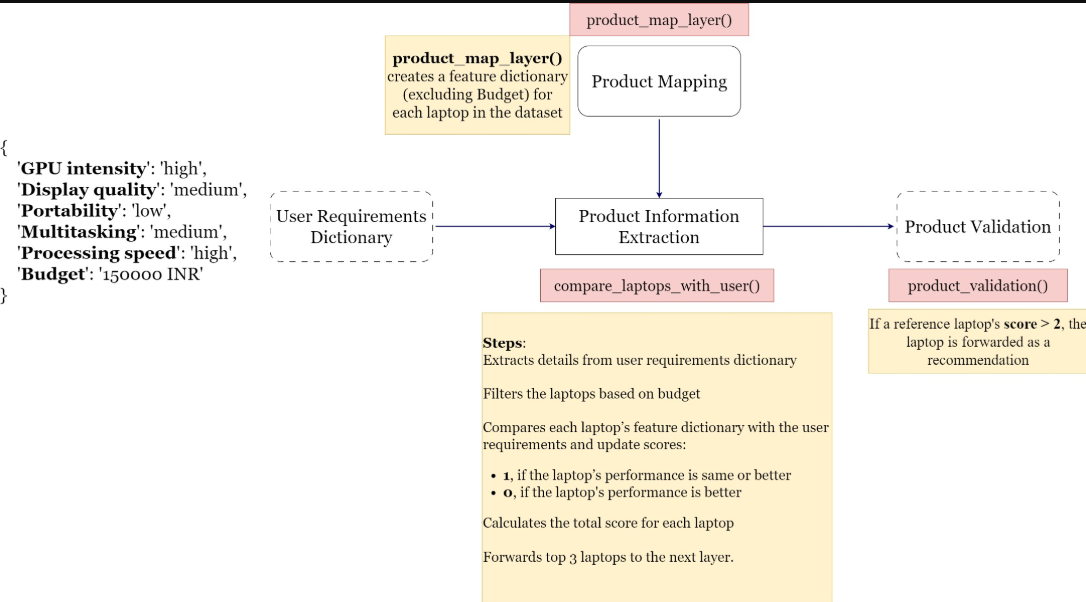

### 3.3 Implementing the Product Mapping and Information Extraction Layers

In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary.
<br>
Next we will extract the top 3 laptop recommendations based on user's requirements.

This stage consists of the following helper functions that will implement the information extraction and product matching layers.

### `product_map_layer()`:

This function is responsible for extracting key features and criteria from laptop descriptions. Here's a breakdown of how it works:

-  Use a prompt that assign it the role of a Laptop Specifications Classifier, whose objective is to extract key features and classify them based on laptop descriptions.

- Provide step-by-step instructions for extracting laptop features from description.

- Assign specific rules for each feature (e.g., GPU Intensity, Display Quality, Portability, Multitasking, Processing Speed) and associate them with the appropriate classification value (Low, Medium, or High).

- Includes Few Shot Prompting (sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction and classification process. `using function calling API method`

In [67]:
def product_map_layer(description):
    tools = [
        {
            "name": "classify_laptop_specs",
            "description": "Classifies laptop specifications from the description into predefined keys and values.",
            "parameters": {
                "type": "object",
                "properties": {
                    "GPU_intensity": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Display_quality": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Portability": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Multitasking": {"type": "string", "enum": ["low", "medium", "high"]},
                    "Processing_speed": {"type": "string", "enum": ["low", "medium", "high"]},
                },
                "required": [
                    "GPU_intensity",
                    "Display_quality",
                    "Portability",
                    "Multitasking",
                    "Processing_speed",
                ],
            },
        }
    ]

    system_message = f"""
    You are a high-level laptop specifications classifier. Given a description of a laptop, extract values for the keys:
    GPU intensity, Display quality, Portability, Multitasking, and Processing speed. Use the predefined classifications:
    - GPU intensity: low, medium, high
    - Display quality: low, medium, high
    - Portability: low, medium, high
    - Multitasking: low, medium, high
    - Processing speed: low, medium, high
    Ensure the response is valid and matches the schema exactly.
    """

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": description},
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        functions=tools,
        function_call={"name": "classify_laptop_specs"},
    )

    # Extract and return the structured response
    final_output = response.choices[0].message.function_call.arguments
    return final_output


In [68]:
#testing the above function:
laptop_description_1 = f"""
The Dell Inspiron is a versatile laptop that combines powerful performance and affordability.
It features an Intel Core i5 processor clocked at 2.4 GHz, ensuring smooth multitasking and efficient computing.
With 8GB of RAM and an SSD, it offers quick data access and ample storage capacity.
The laptop sports a vibrant 15.6" LCD display with a resolution of 1920x1080, delivering crisp visuals and immersive viewing experience.
Weighing just 2.5 kg, it is highly portable, making it ideal for on-the-go usage.
Additionally, it boasts an Intel UHD GPU for decent graphical performance and a backlit keyboard for enhanced typing convenience.
With a one-year warranty and a battery life of up to 6 hours, the Dell Inspiron is a reliable companion for work or entertainment.
All these features are packed at an affordable price of 35,000, making it an excellent choice for budget-conscious users.
"""

In [70]:
product_map_layer(laptop_description_1)

'{"GPU_intensity":"medium","Display_quality":"high","Portability":"medium","Multitasking":"high","Processing_speed":"medium"}'

Let's now apply this function to the entire laptop dataset

In [71]:
df["feature"]=df["Description"].apply(lambda x: product_map_layer(x))

In [72]:
df.to_csv("laptop_features.csv",index=False,header=True)

### `compare_laptops_with_user()`:

This function compares the user's profile with the different laptops and come back with the top  recommendations. It will perform the following steps:
    - It will take the user requirements dictionary as input
    - Filter the laptops based on their price, keeping only the ones within the user's budget.
    - Calculate a score for each laptop based on how well it matches the user's requirements.
    - Sort the laptops based on their scores in descending order.
    - Return the top 3 laptops as a JSON-formatted string.
    

In [73]:
def compare_laptop_with_user(user_response):

    laptop_df = pd.read_csv("laptop_features.csv")
    user_requirements = user_response 
    
    # Extract budget and convert to an integer
    try:
        budget = user_requirements.get('Budget', '0')
    except ValueError:
        raise ValueError("Invalid budget format in user response")

    filtered_df = laptop_df.copy()
    filtered_df['Price'] = filtered_df['Price'].str.replace(",", "").astype(int)
    filtered_df = filtered_df[filtered_df['Price'] <= budget].copy()

    mappings = {'low': 0, 'medium': 1, 'high': 2}
    filtered_df['Score'] = 0

    # Iterate over each laptop to calculate the match score
    for index, row in filtered_df.iterrows():
        product_match_str = row['feature']  
        laptop_values = dictionary_present(product_match_str) 
        score = 0

        # Compare user requirements with laptop features
        for key, user_value in user_requirements.items():
            if key == 'Budget':
                continue
            laptop_value = laptop_values.get(key, None)
            laptop_mapping = mappings.get(laptop_value, -1)
            user_mapping = mappings.get(user_value, -1)

            if laptop_mapping >= user_mapping and laptop_mapping != -1 and user_mapping != -1:
                score += 1

        filtered_df.at[index, 'Score'] = score

    # Select the top 3 laptops based on scores
    top_laptops_df = filtered_df.drop('feature', axis=1)
    top_laptops_df = top_laptops_df.sort_values(ascending=False, by='Score').head(3)

    # Convert the top laptops DataFrame to JSON
    top_laptops_json_values = top_laptops_df.to_json(orient='records')

    return top_laptops_json_values

In [74]:
#testing the above function:
top_3_laptops=compare_laptop_with_user(response_dict_n)

In [76]:
# Get output in JSON Format
top_3_laptops_json = json.loads(top_3_laptops)
# type(top_3_laptops_json)
top_3_laptops_json

[{'Brand': 'MSI',
  'Model Name': 'GL65',
  'Core': 'i7',
  'CPU Manufacturer': 'Intel',
  'Clock Speed': '2.6 GHz',
  'RAM Size': '16GB',
  'Storage Type': 'HDD+SSD',
  'Display Type': 'IPS',
  'Display Size': '15.6"',
  'Graphics Processor': 'NVIDIA GTX',
  'Screen Resolution': '1920x1080',
  'OS': 'Windows 10',
  'Laptop Weight': '2.3 kg',
  'Special Features': 'RGB Keyboard',
  'Warranty': '2 years',
  'Average Battery Life': '4 hours',
  'Price': 55000,
  'Description': 'The MSI GL65 is a high-performance laptop designed for gaming enthusiasts. Powered by an Intel Core i7 processor running at 2.6 GHz, it delivers exceptional processing power for smooth gaming and demanding tasks. With 16GB of RAM and a combination of HDD and SSD storage, it offers ample memory and fast data access. The laptop features a 15.6" IPS display with a resolution of 1920x1080, ensuring vivid colors and wide viewing angles for an immersive gaming experience. Equipped with an NVIDIA GTX graphics card, it pr

### `product_validation_layer()`:

This function verifies that the laptop recommendations are good enough, has score greater than 2, and matches the user's requirements.

In [77]:
def product_validation_layer(laptop_recomendation):
    data=json.loads(laptop_recomendation)
    data1=[]
    for i in range(len(data)):
        if data[i]["Score"]>=2:
            data1.append(data[i])
    return data1

In [78]:
validated_data=product_validation_layer(top_3_laptops)
validated_data

[{'Brand': 'MSI',
  'Model Name': 'GL65',
  'Core': 'i7',
  'CPU Manufacturer': 'Intel',
  'Clock Speed': '2.6 GHz',
  'RAM Size': '16GB',
  'Storage Type': 'HDD+SSD',
  'Display Type': 'IPS',
  'Display Size': '15.6"',
  'Graphics Processor': 'NVIDIA GTX',
  'Screen Resolution': '1920x1080',
  'OS': 'Windows 10',
  'Laptop Weight': '2.3 kg',
  'Special Features': 'RGB Keyboard',
  'Warranty': '2 years',
  'Average Battery Life': '4 hours',
  'Price': 55000,
  'Description': 'The MSI GL65 is a high-performance laptop designed for gaming enthusiasts. Powered by an Intel Core i7 processor running at 2.6 GHz, it delivers exceptional processing power for smooth gaming and demanding tasks. With 16GB of RAM and a combination of HDD and SSD storage, it offers ample memory and fast data access. The laptop features a 15.6" IPS display with a resolution of 1920x1080, ensuring vivid colors and wide viewing angles for an immersive gaming experience. Equipped with an NVIDIA GTX graphics card, it pr

Now that you the top 3 laptops extracted, let's pass it to the recommendation layer that'll send it to the user and the user can ask questions around it.

## Stage 3

### 3.4: Product Recommendation Layer

Finally, we come to the product recommendation layer. It takes the output from the `compare_laptops_with_user` function in the previous layer and provides the recommendations to the user. It has the following steps.
1. Initialize the conversation for recommendation.
2. Generate the recommendations and display in a presentable format.
3. Ask questions basis the recommendations.


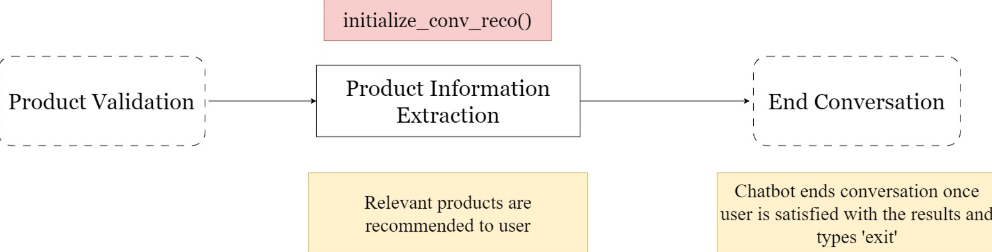

In [95]:
def initialize_conv_reco(products):

    system_message=f"""You are an intelligent system that goes through the laptop details provided and helps the user with any queries they
     have regarding the laptop. Remember to answer the questions asked in lines with the user's profile.
    Start off the conversation with summary of the top laptops provided as follows:
    1. <Laptop Name> : <Top features of the laptop> : <Price>
    2. <Laptop Name> : <Top features of the laptop> : <Price>"""

    user_message=f""" Here is the list of products for the user {products}"""

    conversation=[{"role":"system","content":system_message},
                  {"role":"user","content":user_message}]
    
    recommendation=get_chat_completions(conversation)
    return recommendation

In [96]:
#testing the above function:
debug_initialize_recomendation=initialize_conv_reco(top_3_laptops)
debug_initialize_recomendation

'1. MSI GL65: Intel Core i7 processor, 16GB RAM, NVIDIA GTX graphics, 15.6" IPS display, RGB Keyboard, 2 years warranty, Price: 55,000\n2. Lenovo ThinkPad: AMD Ryzen 7 processor, 16GB RAM, NVIDIA GTX graphics, 14" IPS display, Backlit Keyboard, 3 years warranty, Price: 60,000\n3. Acer Predator: Intel Core i7 processor, 16GB RAM, NVIDIA GTX graphics, 17.3" IPS display, Dual Cooling Fans, 1 year warranty, Price: 80,000\n\nHow can I assist you further with these laptop options?'

## Combining all the 3 stages

In this layer, we combine all the three stages that we defined above.

`Stage 1` + `Stage 2` + `Stage 3`

### 3.5 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [109]:
def dialogue_mgmt_system():

    conversation=initialize_conversation()
    response=get_chat_completions(conversation)
    display(response + '\n')

    top_3_laptops=None
    user_input=''

    while user_input!="exit":
        user_input=input(" ")

        moderation=moderation_check(user_input)
        if moderation=="Flagged":
            print("response is flagged please restart your conversation")
            break
        

        if top_3_laptops is None:
            conversation.append({"role":"user","content":user_input})
            print("user_response: "+str(user_input)+"\n")
            assistant_response=get_chat_completions(conversation)
            moderation=moderation_check(assistant_response)
            if moderation=="Flagged":
                print("response is flagged please restart your conversation")
                break
            
            confirmation=intent_confirmation(assistant_response)
            if confirmation.get("result")=="No":
                print("assistant_response: "+str(assistant_response)+"\n")
                conversation.append({"role":"assistant","content":str(assistant_response)})
            else:
                print("assistant_response: "+str(assistant_response)+"\n")
                print("Variables extracted")
                response_dict=dictionary_present(assistant_response)

                print("Fetching the laptops as per the user requirements")
                top_3_laptops=compare_laptop_with_user(response_dict)
                print("The top 3 laptops are: ",top_3_laptops)

                validated_data=product_validation_layer(top_3_laptops)
                conversation_reco=initialize_conv_reco(validated_data)
                conversation_reco.append({"role":"user","content":"This is my user profile"+str(response_dict)})

                final_recomendation=get_chat_completions(conversation_reco)
                moderation=moderation_check(final_recomendation)
                if moderation=="Flagged":
                    print("response is flagged please restart your conversation")
                    break
                conversation_reco.append({"role":"assistant","content":final_recomendation})
                print("the final recommendation is: ",final_recomendation)
            
        else:
            conversation_reco.append({"role":"user","content":user_input})
            assistant_response=get_chat_completions(conversation_reco)
            moderation=moderation_check(assistant_response)
            if moderation=="Flagged":
                print("response is flagged please restart your conversation")
                break
            conversation_reco.append({"role":"assistant","content":assistant_response})
            print("assistant_response: "+assistant_response+"\n")       



In [110]:
dialogue_mgmt_system()

'Hello! How can I assist you today?\n'

user_response: i want information about laptops

assistant_response: Hi there! I'd be happy to help you with information about laptops. Could you please tell me a bit more about what you are looking for in a laptop?

user_response: I am a coder, i require a laptop with higher RAM

assistant_response: Great to know that you are a coder! As a coder, having higher RAM is crucial for handling multiple applications and tasks simultaneously. 
Do you also require a laptop with high processing speed for coding efficiently? And what is your budget range for the laptop?

user_response: yes, i require high processing speed. My budget is 70,000

assistant_response: Awesome! So, you are looking for a laptop with higher RAM, high processing speed, and your budget is 70,000. 
Just to confirm, do you prefer a laptop with a high GPU for any specific coding tasks, or is it not a priority for you?

user_response: GPU can be medium

assistant_response: Thank you for the information! Based on our conversat